# In this notebook, we run generation with a trained channel-conditioning model

In [1]:
!pip install -r requirements.txt

In [2]:
import os
from argparse import ArgumentParser
from time import time
import matplotlib.pyplot as plt
from copy import deepcopy
import inspect
import gc
import numpy as np
import math

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.nn import L1Loss
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.utils import save_image
from torchvision.transforms import Compose, ToTensor, Lambda, RandomAffine, Normalize
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint

2024-06-02 04:03:42.741018: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
from CIGN_channel.model_with_channel_conditioning import CIGNWithChannelConditioning
from idempotent_networks import IdempotentNetworkWithConditioning

In [4]:
# Initialize model
prior = torch.distributions.Normal(torch.zeros(1, 28, 28), torch.ones(1, 28, 28))
net = CIGNWithChannelConditioning(data_channels=1, 
                                  latent_dim=64, 
                                  intermediate_dim=128, 
                                  embedding_dim=5)

In [5]:
model = (
    IdempotentNetworkWithConditioning.load_from_checkpoint(
        "checkpoints_with_channel_conditioning/1716763544/epoch=24_best_checkpoint.ckpt", 
        prior=prior, 
        model=net,
        map_location=torch.device('cpu')
    )
    .eval()
)

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.2.0.post0, which is newer than your current Lightning version: v2.0.9
  rank_zero_warn(


### Utility functions to visualize generated images

In [6]:
def map_noise_to_label(model, noise, label):
    y = torch.full(
        (noise.shape[0],),
        label
    )
    
    return model(noise, y)[0]

def plot_noise_to_label(model, noise, label, path = None):
    generated_images = map_noise_to_label(model, noise, label)
    
    num_generated_images = generated_images.shape[0]
    
    f, axarr = plt.subplots(math.ceil(num_generated_images / 2), 2)
    
    for idx, image in enumerate(generated_images):
        row_number = math.floor(idx / 2)
        col_number = int(math.remainder(idx, 2))
        axarr[row_number, col_number].imshow(
            generated_images[idx].squeeze().detach().numpy(), 
            cmap = 'gray')
        
        axarr[row_number, col_number].set_axis_off()
        
    if path:
        plt.savefig(path, bbox_inches='tight')

In [7]:
def generate_many_digits_from_same_noise(model, noise, path=None):
    
    generated_list = []
    for label in range(10):
        y = torch.full(
            (noise.shape[0],),
            label
        )

        generated_list.append(model(noise, y)[0])
        
    generated_images = torch.concat(generated_list)
    
    f, axarr = plt.subplots(noise.shape[0] * 5, 2)
    
    for idx, image in enumerate(generated_images):
        row_number = math.floor(idx / 2)
        col_number = int(math.remainder(idx, 2))
        axarr[row_number, col_number].imshow(
            generated_images[idx].squeeze().detach().numpy(), 
            cmap = 'gray')
        
        axarr[row_number, col_number].set_axis_off()
        
    if path:
        plt.savefig(path, bbox_inches='tight')

In [8]:
many_noise = model.prior.sample_n(n = 6)
many_noise.shape

/opt/conda/envs/sagemaker-distribution/lib/python3.10/site-packages/torch/distributions/distribution.py:173: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


torch.Size([6, 1, 28, 28])

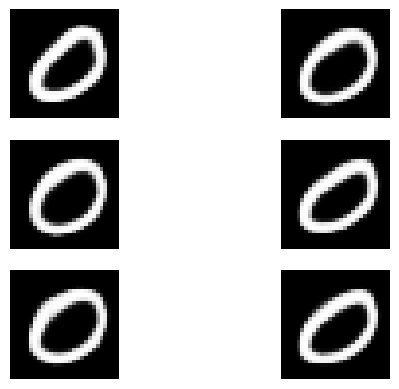

In [9]:
plot_noise_to_label(model, many_noise, label = 0, 
                    #path = 'zero.png'
                   )

In [14]:
single_noise = model.prior.sample_n(n = 1)
single_noise.shape

torch.Size([1, 1, 28, 28])

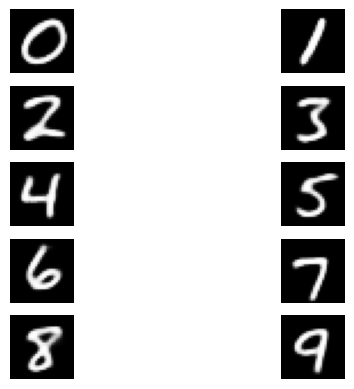

In [16]:
generate_many_digits_from_same_noise(
    model, 
    single_noise, 
    #path = 'sample_images/channel_conditioning/all_digits - channel large.png'
)